In [ ]:
!pip install -U langchain_community langchain-openai langchain langgraph

In [21]:
from typing import TypedDict, Literal, List, Dict, Any
import pandas as pd
import json
import re 
import math
import random
from pathlib import Path
from os import getenv
from dotenv import load_dotenv
load_dotenv()

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableMap
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    openai_api_key=getenv("OPENAI_API_KEY")
)

In [22]:
import json

def get_subtree_by_path(tree, path):
    """
    По заданному пути (список ключей) от корня, возвращает поддерево.
    Если последний узел имеет ключ "nodes", возвращается именно его содержимое.
    """
    current = tree
    for key in path:
        if key in current:
            current = current[key]
            if key != path[-1]:
                if "nodes" in current:
                    current = current["nodes"]
                else:
                    return None
        else:
            return None
            
    if isinstance(current, dict) and "nodes" in current:
        return current["nodes"]
    return current

def extract_nodes_at_depth(subtree, target_depth):
    if not isinstance(subtree, dict):
        return {}
    result = {}
    def traverse(current, current_depth):
        if not isinstance(current, dict):
            return
        if current_depth == target_depth:
            for key, node in current.items():
                if isinstance(node, dict):
                    result[key] = {k: v for k, v in node.items() if k != "nodes"}
        else:
            for key, node in current.items():
                if isinstance(node, dict) and "nodes" in node:
                    if isinstance(node["nodes"], dict):
                        traverse(node["nodes"], current_depth + 1)
    traverse(subtree, 0)
    return result

def get_nodes_from_branch(tree, parent_path, target_depth):
    """
    Возвращает словарь узлов, начиная с родительской ветки, определяемой parent_path (список ключей),
    и затем выбирает узлы, находящиеся на target_depth (отсчитанная от найденной ветки).
    """
    subtree = get_subtree_by_path(tree, parent_path)
    if subtree is None:
        return {}
    return extract_nodes_at_depth(subtree, target_depth)

with open('file_cwe_tree.json', encoding='utf-8') as f:
    cwe_tree = json.load(f)

In [23]:
parent_path = []
#target_depth = 0
nodes = get_nodes_from_branch(cwe_tree, parent_path, target_depth=0)
print(json.dumps(nodes, indent=2, ensure_ascii=False))

{
  "710": {
    "name": "Improper Adherence to Coding Standards",
    "description": "The product does not follow certain coding rules for development, which can lead to resultant weaknesses or increase the severity of the associated vulnerabilities."
  },
  "664": {
    "name": "Improper Control Of a Resource Through Its Lifetime",
    "description": "Resources often have explicit instructions on how to be created, used and destroyed. When code does not follow these instructions, it can lead to unexpected behaviors and potentially exploitable states. Even without explicit instructions, various principles are expected to be adhered to, such as 'Do not use an object until after its creation is complete,' or 'do not use an object after it has been slated for destruction'. This category contains vulnerabilities such as Out-of-Bounds Write and use-after-free"
  },
  "691": {
    "name": "Insufficient Control Flow Management",
    "description": "The code does not sufficiently manage its c

## Тестовый пример

In [7]:
# 664 -> 118 -> 119 -> 787
example_code = """char * copy_input(char *user_supplied_string){
int i, dst_index;
char *dst_buf = (char*)malloc(4*sizeof(char) * MAX_SIZE);
if ( MAX_SIZE <= strlen(user_supplied_string) ){
die("user string too long, die evil hacker!");
}
dst_index = 0;
for ( i = 0; i < strlen(user_supplied_string); i++ ){
if( '&' == user_supplied_string[i] ){
dst_buf[dst_index++] = '&';
dst_buf[dst_index++] = 'a';
dst_buf[dst_index++] = 'm';
dst_buf[dst_index++] = 'p';
dst_buf[dst_index++] = ';';
}
else if ('<' == user_supplied_string[i] ){

/* encode to &lt; */
}
else dst_buf[dst_index++] = user_supplied_string[i];
}
return dst_buf;
}"""

def dict_to_str(input_dict: Dict[str, Any]) -> str:
    return input_dict["bad_code"]

input_converter = RunnableMap({"bad_code": dict_to_str})
input_data = {"bad_code": example_code}

## 1 Агент уровня PILLAR

In [8]:
parent_path = []
nodes = get_nodes_from_branch(cwe_tree, parent_path, target_depth=0)
pillar_category = nodes

In [9]:
pillar_json_schema = {
    "title": "detect-category",
    "description": """You are a security expert in C-code who reads a code fragment and assigns it to **ONE** category, **ONE**. 
    You have a BLOCKS block that contains CWE-ID and category descriptions for error analysis in a specific domain""",
    "type": "object",
    "properties": {
        "categories": {
            "type": "array",
            "description": "A list of the most likely error categories for the code contained in the BAD_CODE block. In case there are no errors in the code, output an empty list.",
            "items": {
                "type": "string",
                "description": "The error category most likely associated with the code from BAD_CODE.",
                "enum": list(pillar_category.keys())
            },
            "maxItems": 1
        },
        "reasoning": {
            "type": "string",
            "description": "A brief explanation for **ONE** of the `categories` error classes. No more than 3 sentences."
        },
        "confidence": {
            "type": "number",
            "description": "Confidence score in the correctness of the chosen category (from 0 to 1).",
            "minimum": 0,
            "maximum": 1
        },
    },
    "required": ["categories", "reasoning", "confidence"]
}

pillar_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     f"BLOCKS:\n{'\n###\n'.join([f'{i}. **{k}**:\n{v['name']}. {v['description']}' for i, (k, v) in enumerate(pillar_category.items(), start=1)])}"),
    ("user",  """BAD_CODE:\n\n{bad_code}""")
])

pillar_llm = (
    {"bad_code": RunnablePassthrough()}
    | pillar_prompt
    | llm.with_structured_output(pillar_json_schema)
)

In [10]:
pillar_resp = pillar_llm.invoke(input_data)

print("Ответ агента 'pillar':")
print(json.dumps(pillar_resp, indent=2, ensure_ascii=False))

Ответ агента 'pillar':
{
  "categories": [
    "664"
  ],
  "reasoning": "The code does not properly manage the lifetime of the allocated memory for `dst_buf`. If the input string exceeds the expected length, the function may write beyond the allocated buffer, leading to potential out-of-bounds writes. This improper control of the resource can lead to unexpected behaviors and vulnerabilities.",
  "confidence": 0.9
}


## 2 Агент уровня CLASS

In [11]:
parent_path = pillar_resp['categories']
nodes = get_nodes_from_branch(cwe_tree, parent_path, target_depth=0)
class_category = nodes

In [12]:
class_raw_title = f"detect-{pillar_category[pillar_resp['categories'][0]]['name']}"
class_title = re.sub(r'[^a-zA-Z0-9_-]', '_', class_raw_title)

class_json_schema= {
    "title": "detect-category",
    "description": f"""You are a security expert in the field of {pillar_category[pillar_resp['categories'][0]]['name']}, who receives a code fragment and a description of a possible error. 
    You have a BLOCKS block that contains the CWE-ID and descriptions of categories for error analysis in a specific domain. You can classify the code into **ONLY ONE** category, ONE. 
    You can consider the comments about other error classes in the code from the COMMENTS block (although they may not be accurate).""",
    "type": "object",
    "properties": {
        "categories": {
            "type": "array",
            "description": "A list of the most likely error categories for the code contained in the BAD_CODE block. If there are no errors in the code, output an empty list.",
            "items": {
                "type": "string",
                "description": "The error category most likely associated with the code from BAD_CODE.",
                "enum": list(class_category.keys())
            },
            "maxItems": 1
        },
        "reasoning": {
            "type": "string",
            "description": "A brief justification for **ONE** of the selected `categories` error classes. No more than 3 sentences."
        },
        "confidence": {
            "type": "number",
            "description": "Confidence rating in the correctness of the selected category (from 0 to 1).",
            "minimum": 0,
            "maximum": 1
        },
    },
    "required": ["categories", "reasoning", "confidence"]
}

class_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     f"BLOCKS:\n{'\n###\n'.join([f'{i}. **{k}**:\n{v['name']}. {v['description']}' for i, (k, v) in enumerate(class_category.items(), start=1)])}"),
    ("assistant", "COMMENTS: {comment}"),
    ("user",  """BAD_CODE:\n\n{bad_code}""")
])

class_llm = (
    {"bad_code": lambda x: x["bad_code"], "comment": lambda x: x["comment"]}
    | class_prompt
    | llm.with_structured_output(class_json_schema)
)

In [13]:
class_resp = class_llm.invoke({"bad_code": example_code, "comment": pillar_resp['reasoning']})

print("Ответ агента 'class':")
print(json.dumps(class_resp, indent=2, ensure_ascii=False))

Ответ агента 'class':
{
  "categories": [
    "118"
  ],
  "reasoning": "The code improperly accesses the `dst_buf` array without checking if `dst_index` exceeds its allocated size. This can lead to buffer overflows, as the code does not restrict the number of characters written to `dst_buf`, which is a classic case of incorrect access of an indexable resource.",
  "confidence": 0.9
}


## 3 Агент уровня CLASS_2

In [14]:
parent_path = pillar_resp['categories'] + class_resp['categories']
nodes = get_nodes_from_branch(cwe_tree, parent_path, target_depth=0)
class2_category = nodes

In [15]:
class2_raw_title = f"detect {class_category[class_resp['categories'][0]]['name']}"
class2_title = re.sub(r'[^a-zA-Z0-9_-]', '_', class2_raw_title)

class2_json_schema = {
    "title": "detect-category",
    "description": f"""You are a security expert in the field of {class_category[class_resp['categories'][0]]['name']}, who receives a code fragment and a description of a possible error. 
    You have a BLOCKS block that contains the CWE-ID and descriptions of categories for error analysis in a specific area. You can classify the code into **ONE** category.
    You can take into account comments about other error classes in the code from the COMMENTS block (although they may not be accurate).""",
    "type": "object",
    "properties": {
        "categories": {
            "type": "array",
            "description": "A list of the most likely error categories for the code contained in the BAD_CODE block. In the absence of errors in the code, output an empty list.",
            "items": {
                "type": "string",
                "description": "The error category most likely associated with the code from BAD_CODE.",
                "enum": list(class2_category.keys())
            },
            "maxItems": 1
        },
        "reasoning": {
            "type": "string",
            "description": "A brief justification for **ONE** of the selected `categories` error classes. No more than 3 sentences."
        },
        "confidence": {
            "type": "number",
            "description": "Confidence rating in the correctness of the selected category (from 0 to 1).",
            "minimum": 0,
            "maximum": 1
        },
    },
    "required": ["categories", "reasoning", "confidence"]
}

class2_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     f"BLOCKS:\n{'\n###\n'.join([f'{i}. **{k}**:\n{v['name']}. {v['description']}' for i, (k, v) in enumerate(class2_category.items(), start=1)])}"),
    ("assistant", "COMMENTS: {comment}"),
    ("user",  """BAD_CODE:\n\n{bad_code}""")
])

class2_llm = (
    {"bad_code": lambda x: x["bad_code"], "comment": lambda x: x["comment"]}
    | class2_prompt
    | llm.with_structured_output(class2_json_schema)
)

In [16]:
class2_resp = class2_llm.invoke({"bad_code": example_code, "comment": class_resp['reasoning']})

print("Ответ агента 'class2':")
print(json.dumps(class2_resp, indent=2, ensure_ascii=False))

Ответ агента 'class2':
{
  "categories": [
    "119"
  ],
  "reasoning": "The code performs operations on the `dst_buf` array without checking if `dst_index` exceeds its allocated size, which can lead to writing beyond the bounds of the buffer. This is a classic case of improper restriction of operations within the bounds of a memory buffer, potentially causing buffer overflow vulnerabilities. The lack of checks on `dst_index` during the writing process directly relates to the CWE-119 category.",
  "confidence": 0.9
}


## 4 Агент уровня BASE

In [17]:
parent_path = pillar_resp['categories'] + class_resp['categories'] + class2_resp['categories']
nodes = get_nodes_from_branch(cwe_tree, parent_path, target_depth=0)
base_category = nodes

In [18]:
base_raw_title = f"detect {class2_category[class2_resp['categories'][0]]['name']}"
base_title = re.sub(r'[^a-zA-Z0-9_-]', '_', base_raw_title)

base_json_schema = {
    "title": "detect-category",
    "description": f"""You are a security expert in the field of {class2_category[class2_resp['categories'][0]]['name']}, who receives a code fragment and a description of a possible error. 
    You have a BLOCKS block that contains the CWE-ID and descriptions of categories for error analysis in a specific area. You can classify the code into **ONE** category.
    You can take into account comments about other error classes in the code from the COMMENTS block (although they may not be accurate).""",
    "type": "object",
    "properties": {
        "categories": {
            "type": "array",
            "description": "A list of the most likely error categories for the code contained in the BAD_CODE block. In the absence of errors in the code, output an empty list.",
            "items": {
                "type": "string",
                "description": "The error category most likely associated with the code from BAD_CODE.",
                "enum": list(base_category.keys())
            },
            "maxItems": 1
        },
        "reasoning": {
            "type": "string",
            "description": "A brief justification for **ONE** of the selected `categories` error classes. No more than 3 sentences."
        },
        "confidence": {
            "type": "number",
            "description": "Confidence rating in the correctness of the selected category (from 0 to 1).",
            "minimum": 0,
            "maximum": 1
        },
    },
    "required": ["categories", "reasoning", "confidence"]
}

base_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     f"BLOCKS:\n{'\n###\n'.join([f'{i}. **{k}**:\n{v['name']}. {v['description']}' for i, (k, v) in enumerate(base_category.items(), start=1)])}"),
    ("assistant", "COMMENTS: {comment}"),
    ("user",  """BAD_CODE:\n\n{bad_code}""")
])

base_llm = (
    {"bad_code": lambda x: x["bad_code"], "comment": lambda x: x["comment"]}
    | base_prompt
    | llm.with_structured_output(base_json_schema)
)

In [19]:
base_resp = base_llm.invoke({"bad_code": example_code, "comment": class2_resp['reasoning']})

print("Ответ агента 'base':")
print(json.dumps(base_resp, indent=2, ensure_ascii=False))

Ответ агента 'base':
{
  "categories": [
    "787"
  ],
  "reasoning": "The code writes to the `dst_buf` array using the `dst_index` variable without checking if it exceeds the allocated size of the buffer. This can lead to an out-of-bounds write if the `user_supplied_string` is long enough, causing potential buffer overflow vulnerabilities. Therefore, it falls under the category of improper restriction of operations within the bounds of a memory buffer.",
  "confidence": 0.9
}


## 5 Агент уровня VARIANT

In [20]:
parent_path = pillar_resp['categories'] + class_resp['categories'] + class2_resp['categories'] + base_resp['categories']
nodes = get_nodes_from_branch(cwe_tree, parent_path, target_depth=0)
variant_category = nodes

In [21]:
variant_category

{}

In [22]:
variant_raw_title = f"detect {base_category[base_resp['categories'][0]]['name']}"
variant_title = re.sub(r'[^a-zA-Z0-9_-]', '_', variant_raw_title)

variant_json_schema = {
    "title": "detect-category",
    "description": f"""You are a security expert in the field of {base_category[base_resp['categories'][0]]['name']}, who receives a code fragment and a description of a possible error. 
    You have a BLOCKS block that contains the CWE-ID and descriptions of categories for error analysis in a specific area. You can classify the code into **ONE** category.
    You can take into account comments about other error classes in the code from the COMMENTS block (although they may not be accurate).""",
    "type": "object",
    "properties": {
        "categories": {
            "type": "array",
            "description": "A list of the most likely error categories for the code contained in the BAD_CODE block. In case there are no errors in the code, output an empty list.",
            "items": {
                "type": "string",
                "description": "The error category most likely associated with the code from BAD_CODE.",
                "enum": list(variant_category.keys())
            },
            "maxItems": 1
        },
        "reasoning": {
            "type": "string",
            "description": "A brief justification for the **ONE** selected error classes from `categories`. No more than 3 sentences."
        },
        "confidence": {
            "type": "number",
            "description": "Confidence rating in the correctness of the selected category (from 0 to 1).",
            "minimum": 0,
            "maximum": 1
        },
    },
    "required": ["categories", "reasoning", "confidence"]
}

variant_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     f"BLOCKS:\n{'\n###\n'.join([f'{i}. **{k}**:\n{v['name']}. {v['description']}' for i, (k, v) in enumerate(variant_category.items(), start=1)])}"),
    ("assistant", "COMMENTS: {comment}"),
    ("user",  """BAD_CODE:\n\n{bad_code}""")
])

variant_llm = (
    {"bad_code": lambda x: x["bad_code"], "comment": lambda x: x["comment"]}
    | variant_prompt
    | llm.with_structured_output(variant_json_schema)
)

In [23]:
variant_resp = variant_llm.invoke({"bad_code": example_code, "comment": class_resp['reasoning']})

print("Ответ агента 'variant':")
print(json.dumps(variant_resp, indent=2, ensure_ascii=False))

Ответ агента 'variant':
{
  "categories": [
    "CWE-787: Out-of-bounds Write"
  ],
  "reasoning": "The code does not check if `dst_index` exceeds the allocated size of `dst_buf`, which can lead to writing beyond the bounds of the allocated memory. This is a classic case of an Out-of-Bounds Write vulnerability, as the code allows for potentially unsafe memory access. The lack of bounds checking on `dst_index` during the write operations is a clear indicator of this issue.",
  "confidence": 0.9
}


# Парсер дерева CWE

In [3]:
import requests
import json
from tqdm import tqdm 

def get_weakness_info(weakness_id):

    url = f"https://cwe-api.mitre.org/api/v1/cwe/weakness/{weakness_id}"
    try:
        response = requests.get(url, timeout=10)
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе CWE {weakness_id}: {e}")
        return None
        
    if response.status_code == 200:
        data = response.json()
        if "Weaknesses" in data and data["Weaknesses"]:
            weakness = data["Weaknesses"][0]
            description = weakness.get("Description", "")
            # Если есть ExtendedDescription, объединяем его с Description
            extended = weakness.get("ExtendedDescription", "")
            if extended:
                description = f"{description} {extended}".strip()
            return {
                "id": int(weakness["ID"]),
                "name": weakness["Name"], #.replace(" ", ""),
                "description": description
            }
    return None

def get_children(weakness_id):
    
    url = f"https://cwe-api.mitre.org/api/v1/cwe/{weakness_id}/children?view=1000"
    try:
        response = requests.get(url, timeout=10)
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе детей для CWE {weakness_id}: {e}")
        return []
        
    if response.status_code == 200:
        return response.json()
    return []

def build_tree(weakness_id):
    """
    Рекурсивно строит дерево слабостей.
    Для каждого элемента запрашивает его информацию и его дочерние элементы.
    """
    node = get_weakness_info(weakness_id)
    if not node:
        return {}
    
    children = get_children(weakness_id)
    nodes = {}
    for child in tqdm(children, desc=f"Обработка детей CWE {weakness_id}", leave=False):
        child_id = child["ID"]
        child_tree = build_tree(child_id)
        if child_tree:
            nodes.update(child_tree)
    
    result = { node["id"]: {"name": node["name"], "description": node["description"]} }
    if nodes:
        result[node["id"]]["nodes"] = nodes
    return result

if __name__ == "__main__":
    pillar_ids = [682, 703, 691, 693, 435, 697, 664, 707, 710, 284]
    all_trees = {}
    for pid in tqdm(pillar_ids, desc="Обработка pillar CWE"):
        tree = build_tree(pid)
        all_trees.update(tree)
    
    with open("all_cwe_tree_new.json", "w", encoding="utf-8") as f:
        json.dump(all_trees, f, ensure_ascii=False, indent=2)
    print("JSON файл построен и сохранён в all_cwe_tree.json")

Обработка pillar CWE:   0%|                                                                                                                                                                                              | 0/10 [00:01<?, ?it/s]


KeyboardInterrupt: 

# Датасет

In [70]:
df

,func,cwe,true_path,true_lvl0,true_lvl1,true_lvl2,true_lvl3,true_lvl4
0,cdf_read_property_info(const cdf_stream_t *sst...,787,"[664, 118, 119, 787]",664,118,119,787,None
1,"check_termcode(\n int\t\tmax_offset,\n c...",787,"[664, 118, 119, 787]",664,118,119,787,None
2,static void *seq_buf_alloc(unsigned long size)...,787,"[664, 118, 119, 787]",664,118,119,787,None
3,display_dollar(colnr_T col)\n{\n colnr_T sa...,787,"[664, 118, 119, 787]",664,118,119,787,None
4,static void parse_relocation_info(struct MACH0...,787,"[664, 118, 119, 787]",664,118,119,787,None
...,...,...,...,...,...,...,...,...
195,"int SSL_set_session(SSL *s, SSL_SESSION *sessi...",362,"[691, 362]",691,362,None,None,None
196,"TEST_P(SslSocketTest, FailedClientCertificateH...",362,"[691, 362]",691,362,None,None,None
197,"void SSL_CTX_sess_set_new_cb(SSL_CTX *ctx,\n ...",362,"[691, 362]",691,362,None,None,None
198,"static int remove_session_lock(SSL_CTX *ctx, S...",362,"[691, 362]",691,362,None,None,None


In [73]:
import numpy as np

In [186]:
df = pd.read_csv('primevul_top10_500')

In [187]:
df['cwe'].value_counts()

cwe
787    50
476    50
125    50
703    50
416    50
617    50
200    50
20     50
362    50
401    50
Name: count, dtype: int64

In [188]:
df_416 = df[df['cwe'] == 416]

if len(df_416) < 50:
    raise ValueError(f"В датасете только {len(df_416)} строк с cwe=416, а нужно 50")

# случайным образом возьмём 50 примеров
df_50_416 = df_416.sample(n=50, random_state=42).reset_index(drop=True)

In [87]:
df_reduced = (
    df
    .groupby('cwe', group_keys=False)
    .apply(lambda g: g.sample(n=min(len(g), 10), random_state=42))
    .reset_index(drop=True)
)

/tmp/ipykernel_26838/2226607294.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), 10), random_state=42))


In [189]:
df_50_416

,idx,project,commit_id,project_url,commit_url,commit_message,target,func,func_hash,file_name,file_hash,cwe,cve,cve_desc,nvd_url
0,202600,vim,d88934406c5375d88f8f1b65331c9f0cab68cc6c,https://github.com/vim/vim,https://github.com/vim/vim/commit/d88934406c53...,patch 8.2.4895: buffer overflow with invalid c...,1,append_command(char_u *cmd)\n{\n char_u *s ...,85617612987498147368294311510039065479,ex_docmd.c,4.637562e+36,416,CVE-2022-1616,Use after free in append_command in GitHub rep...,https://nvd.nist.gov/vuln/detail/CVE-2022-1616
1,263506,linux,99c23da0eed4fd20cae8243f2b51e10e66aa0951,https://github.com/torvalds/linux,https://github.com/torvalds/linux/commit/99c23...,Bluetooth: sco: Fix lock_sock() blockage by me...,0,static void sco_sock_set_timer(struct sock *sk...,26762028484710638915289302756894264031,sco.c,4.587366e+37,416,CVE-2021-3640,A flaw use-after-free in function sco_sock_sen...,https://nvd.nist.gov/vuln/detail/CVE-2021-3640
2,211695,vim,4c13e5e6763c6eb36a343a2b8235ea227202e952,https://github.com/vim/vim,https://github.com/vim/vim/commit/4c13e5e6763c...,patch 8.2.3949: using freed memory with /\%V\n...,1,"reg_match_visual(void)\n{\n pos_T\ttop, bot...",213127434587581742033304075177767787021,regexp.c,1.541788e+38,416,CVE-2021-4192,vim is vulnerable to Use After Free,https://nvd.nist.gov/vuln/detail/CVE-2021-4192
3,263513,linux,99c23da0eed4fd20cae8243f2b51e10e66aa0951,https://github.com/torvalds/linux,https://github.com/torvalds/linux/commit/99c23...,Bluetooth: sco: Fix lock_sock() blockage by me...,0,static void sco_sock_timeout(struct work_struc...,283724641307106404137007648951603244172,sco.c,4.587366e+37,416,CVE-2021-3640,A flaw use-after-free in function sco_sock_sen...,https://nvd.nist.gov/vuln/detail/CVE-2021-3640
4,197499,gpac,dc7de8d3d604426c7a6e628d90cb9fb88e7b4c2c,https://github.com/gpac/gpac,https://github.com/gpac/gpac/commit/dc7de8d3d6...,fixed #2212,1,GF_Err BD_DecMFFieldVec(GF_BifsDecoder * codec...,181633592491715085539951152559525218380,field_decode.c,2.705304e+37,416,CVE-2022-2453,Use After Free in GitHub repository gpac/gpac ...,https://nvd.nist.gov/vuln/detail/CVE-2022-2453
5,264646,gpac,c535bad50d5812d27ee5b22b54371bddec411514,https://github.com/gpac/gpac,https://github.com/gpac/gpac/commit/c535bad50d...,fixed #2194,0,GF_Err BM_ParseIndexInsert(GF_BifsDecoder *cod...,262129888204506875118703454325452279713,memory_decoder.c,3.846193e+37,416,CVE-2022-1795,Use After Free in GitHub repository gpac/gpac ...,https://nvd.nist.gov/vuln/detail/CVE-2022-1795
6,201885,vim,b55986c52d4cd88a22d0b0b0e8a79547ba13e1d5,https://github.com/vim/vim,https://github.com/vim/vim/commit/b55986c52d4c...,patch 8.2.4646: using buffer line after it has...,1,"regmatch(\n char_u\t*scan,\t\t // Curren...",155703094073588454659918901719534941663,regexp_bt.c,1.044187e+38,416,CVE-2022-1154,Use after free in utf_ptr2char in GitHub repos...,https://nvd.nist.gov/vuln/detail/CVE-2022-1154
7,201343,linux,a3727a8bac0a9e77c70820655fd8715523ba3db7,https://github.com/torvalds/linux,https://git.kernel.org/pub/scm/linux/kernel/gi...,"selinux,smack: fix subjective/objective creden...",1,static int selinux_ptrace_traceme(struct task_...,244235637020461368565337014513482216980,NaN,NaN,416,CVE-2021-43057,An issue was discovered in the Linux kernel be...,https://nvd.nist.gov/vuln/detail/CVE-2021-43057
8,212433,vim,ccfde4d028e891a41e3548323c3d47b06fb0b83e,https://github.com/vim/vim,https://github.com/vim/vim/commit/ccfde4d028e8...,patch 9.0.0389: crash when 'tagfunc' closes th...,1,"do_tag(\n char_u\t*tag,\t\t// tag (pattern)...",163270354086098606424218695920397836600,tag.c,2.563126e+38,416,CVE-2022-3134,Use After Free in GitHub repository vim/vim pr...,https://nvd.nist.gov/vuln/detail/CVE-2022-3134
9,198476,njs,6a07c2156a07ef307b6dcf3c2ca8571a5f1af7a6,https://github.com/nginx/njs,https://github.com/nginx/njs/commit/6a07c2156a...,Fixed recursive async function calls.\n\nPrevi...,1,"njs_await_fulfilled(njs_vm_t *vm, njs_value_t ...",2415187209093

In [190]:
col = ['func', 'cwe']
df_50_416 = df_50_416[col]

In [191]:
df_50_416.to_csv('primevul_416.csv', index=False)

In [70]:
data = ['787','476','125','703','416','617','200','20','362','401','415','369','94','119','190','191','22','284','400','122','89']

In [73]:
df = pd.DataFrame(data, columns=['cwe'])

In [74]:
df

,cwe
0,787
1,476
2,125
3,703
4,416
5,617
6,200
7,20
8,362
9,401


In [75]:
# 1) Загрузите дерево CWE
with open('all_cwe_tree_new.json', 'r', encoding='utf-8') as f:
    cwe_tree = json.load(f)

# 3) Функция для поиска пути от корня до целевого CWE-ID
def find_true_path(tree: dict, target: str, path=None) -> list:
    if path is None:
        path = []
    for key, node in tree.items():
        new_path = path + [key]
        if key == target:
            return new_path
        children = node.get("nodes")
        if isinstance(children, dict):
            found = find_true_path(children, target, new_path)
            if found:
                return found
    return []

df['cwe'] = df['cwe'].astype(str)
# 4) Применяем к каждому примеру
df['true_path'] = df['cwe'].apply(lambda c: find_true_path(cwe_tree, c))

# 5) Распаковываем в отдельные колонки для пяти уровней
max_levels = 5
for lvl in range(max_levels):
    df[f'true_lvl{lvl}'] = df['true_path'].apply(lambda p: p[lvl] if len(p) > lvl else None)

# 6) Смотрим результат
display(df.head())

,cwe,true_path,true_lvl0,true_lvl1,true_lvl2,true_lvl3,true_lvl4
0,787,"[664, 118, 119, 787]",664,118,119,787,None
1,476,"[703, 754, 476]",703,754,476,None,None
2,125,"[664, 118, 119, 125]",664,118,119,125,None
3,703,[703],703,None,None,None,None
4,416,"[664, 118, 119, 825, 416]",664,118,119,825,416


In [77]:
df.to_csv('primevul_cwe_paths_top20.csv', index=False)

# Тесты системы БЕЗ MCTS

In [21]:
import pandas as pd

agent_chains = {
    0: pillar_llm,
    1: class_llm,
    2: class2_llm,
    3: base_llm,
    4: variant_llm
}

def automated_chain(bad_code):
    iterations = []      
    parent_path = []     
    prev_reasoning = ""   
    level = 0
    
    while level in agent_chains:
        agent = agent_chains[level]
        
        if level == 0:
            resp = agent.invoke(bad_code)
        else:
            resp = agent.invoke({"bad_code": bad_code, "comment": prev_reasoning})
        
        iterations.append({
            "level": level,
            "response": resp
        })
        
        # Обновляем обоснование для следующего вызова и путь
        prev_reasoning = resp.get("reasoning", "")
        chosen = resp.get("categories", [])
        parent_path.extend(chosen)
        
        nodes = get_nodes_from_branch(cwe_tree, parent_path, target_depth=0)
        if not nodes:
            break
        
        level += 1
        
    return iterations, parent_path

_, final_path = automated_chain(example_code)
print(final_path)

# for it in iterations:
#     level = it["level"]
#     resp = it["response"]
#     #print(f"Level {level+1}:")
#     #print(f"  Categories: {resp.get('categories')}")
#     #print(f"  Reasoning: {resp.get('reasoning')}")
#     if 'confidence' in resp:
#          #print(f"  Confidence: {resp.get('confidence')}")
#     print()

['664', '118', '119', '787']


In [22]:
example_code = "static void seq_set_overflow(struct seq_file *m)\n{\n\tm->count = m->size;\n}"

In [23]:
df = pd.read_json('../agent_llm/476_test.jsonl', lines=True)
df_test = df[df['target'] == 1]

true_labels = []
predictions = []

for idx, row in df_test.iterrows():
    # Используем значение func как bad_code (оно же ground truth)
    bad_code = row['func']
    true_cwe = "476"  # поскольку весь датасет – CWE 362
    
    # Вызываем цепочку агентов для данного bad_code
    _, final_path = automated_chain(bad_code)
    print(final_path)
    
    # final_path остаётся без изменений – сравниваем по последнему элементу
    predicted_cwe = final_path[-1] if final_path else 'UNK'
    
    true_labels.append(true_cwe)
    predictions.append(predicted_cwe)

# Расчёт метрик: сравниваем именно конечное значение (последний элемент final_path)
accuracy = accuracy_score(true_labels, predictions)
weighted_f1 = f1_score(true_labels, predictions, average='weighted')

print("Accuracy (по последнему элементу final_path): {:.4f}".format(accuracy))
print("Weighted F1 (по последнему элементу final_path): {:.4f}".format(weighted_f1))

PermissionDeniedError: Error code: 403 - {'error': {'code': 'unsupported_country_region_territory', 'message': 'Country, region, or territory not supported', 'param': None, 'type': 'request_forbidden'}}

# Одиночная LLM

In [31]:
single_json_schema = {
    "title": "detect-category",
    "description": """You are a best security expert in C-code who reads a code fragment and assigns it to CWE category.""",
    "type": "object",
    "properties": {
        "category": {
            "type": "integer",
            "description": "The CWE category"
        },
        "reasoning": {
            "type": "string",
            "description": "A brief explanation for **ONE** of the `categories` error classes. No more than 3 sentences."
        },
        "confidence": {
            "type": "number",
            "description": "Confidence score in the correctness of the chosen category (from 0 to 1).",
            "minimum": 0,
            "maximum": 1
        },
    },
    "required": ["category", "reasoning", "confidence"]
}

single_prompt = ChatPromptTemplate.from_messages([("user",  "BAD_CODE: {bad_code}")])

single_llm = (
    {"bad_code": RunnablePassthrough()}
    | single_prompt
    | llm.with_structured_output(single_json_schema)
)

In [32]:
single_resp = single_llm.invoke(example_code)

In [33]:
single_resp

{'category': 787,
 'reasoning': 'The code allocates a buffer based on a fixed size (4 times MAX_SIZE) but does not properly check if the destination buffer can accommodate the entire user-supplied string, leading to a potential buffer overflow. This is a classic case of improper handling of user input sizes, which can lead to security vulnerabilities. The lack of bounds checking on the destination buffer is a clear indicator of this issue.',
 'confidence': 0.9}

In [214]:
single_resp.get("category", [])

190

# Метрики

In [34]:
df_balanced['cwe'].value_counts()

cwe
787    50
476    50
125    50
703    50
416    50
617    50
200    50
20     50
362    50
401    50
Name: count, dtype: int64

In [35]:
cwe_to_remove = [125, 703, 617, 200, 20, 401]

# Шаг 3: Удаление строк, содержащих эти CWE
df_filtered = df_balanced[~df_balanced['cwe'].isin(cwe_to_remove)]

# Шаг 4: Сброс индекса (если нужно)
df_filtered = df_filtered.reset_index(drop=True)

In [53]:
df_filtered.to_csv('primevul_4cwe_test.csv', index=False)

In [196]:
import json
import pandas as pd

# 1) Загрузите дерево CWE
with open('file_cwe_tree.json', 'r', encoding='utf-8') as f:
    cwe_tree = json.load(f)

# 3) Функция для поиска пути от корня до целевого CWE-ID
def find_true_path(tree: dict, target: str, path=None) -> list:
    if path is None:
        path = []
    for key, node in tree.items():
        new_path = path + [key]
        if key == target:
            return new_path
        children = node.get("nodes")
        if isinstance(children, dict):
            found = find_true_path(children, target, new_path)
            if found:
                return found
    return []

# 4) Применяем к каждому примеру
df['true_path'] = df['cwe'].apply(lambda c: find_true_path(cwe_tree, c))

# 5) Распаковываем в отдельные колонки для пяти уровней
max_levels = 5
for lvl in range(max_levels):
    df[f'true_lvl{lvl}'] = df['true_path'].apply(lambda p: p[lvl] if len(p) > lvl else None)

# 6) Смотрим результат
display(df.head())

,func,cwe,true_path,true_lvl0,true_lvl1,true_lvl2,true_lvl3,true_lvl4
0,append_command(char_u *cmd)\n{\n char_u *s ...,416,"[664, 118, 119, 825, 416]",664,118,119,825,416
1,static void sco_sock_set_timer(struct sock *sk...,416,"[664, 118, 119, 825, 416]",664,118,119,825,416
2,"reg_match_visual(void)\n{\n pos_T\ttop, bot...",416,"[664, 118, 119, 825, 416]",664,118,119,825,416
3,static void sco_sock_timeout(struct work_struc...,416,"[664, 118, 119, 825, 416]",664,118,119,825,416
4,GF_Err BD_DecMFFieldVec(GF_BifsDecoder * codec...,416,"[664, 118, 119, 825, 416]",664,118,119,825,416


In [199]:
from tqdm.notebook import tqdm

# 1) Сбор путей с ручным обновлением
true_paths = []
pred_paths = []

pbar = tqdm(total=len(df), desc="Processing examples")
for _, row in df_reduced.iterrows():
    code = row['func']
    _, pred_path = automated_chain(code)
    true_paths.append(find_true_path(cwe_tree, row['cwe']))
    pred_paths.append(pred_path)
    pbar.update(1)
pbar.close()

df['true_path'] = true_paths
df['pred_path'] = pred_paths

# 2) Распаковка по уровням
num_levels = 5
for lvl in range(num_levels):
    df[f'true_l{lvl}'] = df['true_path'].apply(lambda p: p[lvl] if len(p) > lvl else None)
    df[f'pred_l{lvl}'] = df['pred_path'].apply(lambda p: p[lvl] if len(p) > lvl else None)

# 3) Подсчёт accuracy по уровням
metrics = {}
for lvl in range(num_levels):
    mask = df[f'true_l{lvl}'].notna()
    correct = (df.loc[mask, f'true_l{lvl}'] == df.loc[mask, f'pred_l{lvl}']).sum()
    total = mask.sum()
    metrics[f'level_{lvl}_accuracy'] = correct / total if total > 0 else None

# 4) Вывод результатов
print("\nAccuracy per level:")
for lvl, acc in metrics.items():
    if acc is None:
        print(f"{lvl}: None")
    else:
        print(f"{lvl}: {acc:.3f}")

Processing examples:   0%|          | 0/50 [00:00<?, ?it/s]


Accuracy per level:
level_0_accuracy: 0.960
level_1_accuracy: 0.260
level_2_accuracy: 0.960
level_3_accuracy: 0.220
level_4_accuracy: None


In [200]:
df

,func,cwe,true_path,true_lvl0,true_lvl1,true_lvl2,true_lvl3,true_lvl4,pred_path,true_l0,pred_l0,true_l1,pred_l1,true_l2,pred_l2,true_l3,pred_l3,true_l4,pred_l4
0,append_command(char_u *cmd)\n{\n char_u *s ...,416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 400, 119]",664,664,118,400,119,119,787,None,None,None
1,static void sco_sock_set_timer(struct sock *sk...,416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 400, 119]",664,664,118,400,119,119,787,None,None,None
2,"reg_match_visual(void)\n{\n pos_T\ttop, bot...",416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 118, 119, 787]",664,664,118,118,119,119,787,787,None,None
3,static void sco_sock_timeout(struct work_struc...,416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 400, 119]",664,664,118,400,119,119,787,None,None,None
4,GF_Err BD_DecMFFieldVec(GF_BifsDecoder * codec...,416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 400, 119]",664,664,118,400,119,119,787,None,None,None
5,GF_Err BM_ParseIndexInsert(GF_BifsDecoder *cod...,416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 118, 119, 787]",664,664,118,118,119,119,787,787,None,None
6,"regmatch(\n char_u\t*scan,\t\t // Curren...",416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 400, 119]",664,664,118,400,119,119,787,None,None,None
7,static int selinux_ptrace_traceme(struct task_...,416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 400, 119]",664,664,118,400,119,119,787,None,None,None
8,"do_tag(\n char_u\t*tag,\t\t// tag (pattern)...",416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 118, 119, 787]",664,664,118,118,119,119,787,787,None,None
9,"njs_await_fulfilled(njs_vm_t *vm, njs_value_t ...",416,"[664, 118, 119, 787]",664,118,119,825,416,"[691, 118]",664,691,118,118,119,None,787,None,None,None


In [201]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score

# 1) Пробегаемся по всем примерам и собираем предсказания
pred_labels = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Single-LLM inference"):
    code = row['func']
    resp = single_llm.invoke({"bad_code": code})
    pred_labels.append(str(resp.get("category")))

# 2) Записываем в новую колонку
df['pred_single'] = pred_labels

# 3) Считаем метрики
y_true = df['cwe'].astype(str)
y_pred = df['pred_single']

accuracy    = accuracy_score(y_true, y_pred)
weighted_f1 = f1_score   (y_true, y_pred, average='weighted', zero_division=0)

print(f"Single LLM Accuracy   : {accuracy:.3f}")
print(f"Single LLM Weighted F1: {weighted_f1:.3f}")

# 4) Глянем первые строки с прогнозом
df.head()

Single-LLM inference:   0%|          | 0/50 [00:00<?, ?it/s]

Single LLM Accuracy   : 0.040
Single LLM Weighted F1: 0.077


,func,cwe,true_path,true_lvl0,true_lvl1,true_lvl2,true_lvl3,true_lvl4,pred_path,true_l0,pred_l0,true_l1,pred_l1,true_l2,pred_l2,true_l3,pred_l3,true_l4,pred_l4,pred_single
0,append_command(char_u *cmd)\n{\n char_u *s ...,416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 400, 119]",664,664,118,400,119,119,787,None,None,None,119
1,static void sco_sock_set_timer(struct sock *sk...,416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 400, 119]",664,664,118,400,119,119,787,None,None,None,20
2,"reg_match_visual(void)\n{\n pos_T\ttop, bot...",416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 118, 119, 787]",664,664,118,118,119,119,787,787,None,None,119
3,static void sco_sock_timeout(struct work_struc...,416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 400, 119]",664,664,118,400,119,119,787,None,None,None,119
4,GF_Err BD_DecMFFieldVec(GF_BifsDecoder * codec...,416,"[664, 118, 119, 787]",664,118,119,825,416,"[664, 400, 119]",664,664,118,400,119,119,787,None,None,None,121


In [202]:
df.to_csv('metrics_416.csv', index=False)

## Тест системы с MCTS

In [27]:
import asyncio
from concurrent.futures import ThreadPoolExecutor
import random
import math
from functools import lru_cache
from typing import Dict, Any, List

In [28]:
def evaluate_reasoning(prompt: str) -> float:
    """
    Обращается к LLM для оценки логичности и обоснованности текстового обоснования.
    Запрос включает дополнительный контекст (код и описание выбранной категории).
    Возвращает оценку по шкале от 0 до 1.
    """
    response = llm.invoke(prompt)
    # Если объект response имеет атрибут content, используем его
    if hasattr(response, "content"):
        response_text = response.content
    else:
        response_text = str(response)
    try:
        rating = float(response_text.strip())
    except Exception as e:
        rating = 0.5111  # Значение по умолчанию, если преобразование не удалось
    return rating

def get_initial_reward(agent_output: Dict[str, Any], bad_code: str, category: Dict[str, Any]) -> float:
    """
    Формирует запрос для оценки начального вознаграждения r0.
    Использует текст обоснования (reasoning) агента, входной код (bad_code) и описание выбранной категории.
    """
    reasoning_text = agent_output.get("reasoning", "")
    # Извлекаем выбранную категорию (предполагается, что список содержит один элемент)
    chosen_category = agent_output.get("categories", ["Не указано"])[0]
    # Получаем информацию о выбранной категории из словаря category
    category_info = category.get(chosen_category, {})
    category_desc = category_info.get("description", "Описание не найдено")
    
    prompt = (
        f"Considering the following data:\n\n"
        f"Original CWE category description:\n{category_desc}\n\n"
        f"Code:\n{bad_code}\n\n"
        f"Reasoning for selection:\n{reasoning_text}\n\n"
        f"Evaluate how logical and well-justified the above reasoning is for selecting the specified CWE category. "
        f"Rate on a scale from 0 to 1, where 1 means the reasoning is maximally correct and complete. "
        f"Your answer must be ONLY a number."
    )
    r0 = evaluate_reasoning(prompt)
    return r0

In [30]:
executor = ThreadPoolExecutor(max_workers=10)

@lru_cache(maxsize=None)
def cached_nodes(path_tuple: tuple) -> Dict[str, Any]:
    return get_nodes_from_branch(cwe_tree, list(path_tuple), target_depth=0)

class Node:
    def __init__(self, agent_output: Dict[str, Any], parent: 'Node' = None):
        self.agent_output = agent_output
        self.parent = parent
        self.children: List[Node] = []
        self.n = 0
        self.total_reward = 0.0
        self._r0 = agent_output.get("_r0", 0.0)

    @property
    def avg_reward(self) -> float:
        return self.total_reward / self.n if self.n > 0 else 0.0

def compute_Q(node: Node) -> float:
    confidence = float(node.agent_output.get("confidence", 0.5))
    return max(0.0, min(1.0, confidence * node._r0 + (1 - confidence) * node.avg_reward))

def compute_UCT_value(node: Node, parent_visits: int, lambda_explore: float) -> float:
    if node.n == 0:
        return float('inf')
    return compute_Q(node) + lambda_explore * math.sqrt(math.log(parent_visits) / node.n)

def select_best_child(node: Node, lambda_explore: float = 0.5) -> Node:
    if not node.children:
        return None
    parent_visits = node.n if node.n > 0 else 1
    return max(node.children, key=lambda c: compute_UCT_value(c, parent_visits, lambda_explore))

def update_node(node: Node, reward: float):
    node.n += 1
    node.total_reward += reward

def update_parents(node: Node, reward: float):
    while node:
        update_node(node, reward)
        node = node.parent

def call_agent(level: int, bad_code: str, comment: str = "", forced: str = None, parent_path: List[str] = None) -> Dict[str, Any]:
    agent = agent_chains[level]
    input_data = {"bad_code": bad_code}
    if comment:
        input_data["comment"] = comment
    if forced:
        input_data["forced"] = forced
    if parent_path is not None:
        input_data["parent_path"] = parent_path
    resp = agent.invoke(input_data)
    category_dict = cached_nodes(tuple(parent_path or []))
    resp["_r0"] = get_initial_reward(resp, bad_code, category_dict)
    return resp

async def call_agent_async(level: int, bad_code: str, comment: str = "", forced: str = None, parent_path: List[str] = None) -> Dict[str, Any]:
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(executor, call_agent, level, bad_code, comment, forced, parent_path)

async def automated_chain_with_mcts_async(bad_code: str, max_iterations: int = 50) -> Node:
    lambda_explore = 0.5

    # Инициализация корня
    root_resp = await call_agent_async(0, bad_code, parent_path=[])
    root = Node(root_resp)
    update_node(root, root._r0)

    for iteration in range(max_iterations):
        # 1. Selection
        node = root
        path: List[str] = []
        while True:
            options = list(cached_nodes(tuple(path)).keys())
            if len(node.children) < len(options):
                break
            best_child = select_best_child(node, lambda_explore)
            if best_child is None:
                break
            node = best_child
            choice = node.agent_output.get("categories", [None])[0]
            path.append(choice)

        # 2. Expansion (если node найден)
        options = list(cached_nodes(tuple(path)).keys())
        expanded = [c.agent_output.get("categories", [None])[0] for c in node.children]
        unexpanded = [opt for opt in options if opt not in expanded]
        if node is not None and unexpanded:
            forced = random.choice(unexpanded)
            resp = await call_agent_async(
                level=len(path),
                bad_code=bad_code,
                comment=node.agent_output.get("reasoning", ""),
                forced=forced,
                parent_path=path.copy()
            )
            child = Node(resp, parent=node)
            update_node(child, child._r0)
            node.children.append(child)
            node = child
            path.append(forced)

        # 3. Simulation (Rollout)
        sim_tasks = []
        sim_path = path.copy()
        lvl = len(sim_path)
        while lvl in agent_chains:
            sim_tasks.append(call_agent_async(
                level=lvl,
                bad_code=bad_code,
                comment=node.agent_output.get("reasoning", ""),
                parent_path=sim_path.copy()
            ))
            sim_path.append(None)
            lvl += 1
        sim_results = await asyncio.gather(*sim_tasks, return_exceptions=True)
        sim_reward = sum(getattr(res, "_r0", 0.0) if not isinstance(res, Exception) else 0.0 for res in sim_results)

        # 4. Backpropagation
        update_parents(node or root, sim_reward)

    return root

def print_tree(node: Node, depth: int = 0):
    indent = "  " * depth
    cat = node.agent_output.get("categories", [])
    print(f"{indent}Level {depth}: {cat} (n={node.n}, avgQ={node.avg_reward:.3f})")
    for child in node.children:
        print_tree(child, depth + 1)

In [33]:
import pandas as pd

df = pd.read_csv('metrics_787.csv')
df.head()

,func,cwe,true_path,true_lvl0,true_lvl1,true_lvl2,true_lvl3,true_lvl4,pred_path,true_l0,pred_l0,true_l1,pred_l1,true_l2,pred_l2,true_l3,pred_l3,true_l4,pred_l4,pred_single
0,append_command(char_u *cmd)\n{\n char_u *s ...,787,"['664', '118', '119', '787']",664,118,119,787,NaN,"['664', '118', '119', '787']",664,664,118,118,119,119.0,787,787.0,NaN,NaN,119
1,PJ_DEF(pj_status_t) pjstun_parse_msg( void *bu...,787,"['664', '118', '119', '787']",664,118,119,787,NaN,"['664', '118', '119', '787']",664,664,118,118,119,119.0,787,787.0,NaN,NaN,121
2,"pcx_write_rle(const byte * from, const byte * ...",787,"['664', '118', '119', '787']",664,118,119,787,NaN,"['664', '118', '119', '787']",664,664,118,118,119,119.0,787,787.0,NaN,NaN,190
3,void HierarchicalBitmapRequester::PrepareForDe...,787,"['664', '118', '119', '787']",664,118,119,787,NaN,"['664', '400', '119']",664,664,118,400,119,119.0,787,NaN,NaN,NaN,682
4,"ins_compl_add(\n char_u\t*str,\n int\t\t...",787,"['664', '118', '119', '787']",664,118,119,787,NaN,"['664', '400', '119']",664,664,118,400,119,119.0,787,NaN,NaN,NaN,119


In [34]:
example_code = df['func'][3]

In [36]:
import nest_asyncio
nest_asyncio.apply()

root_node = asyncio.run(automated_chain_with_mcts_async(example_code, max_iterations=50))
print_tree(root_node)

Level 0: ['664'] (n=51, avgQ=0.016)
  Level 1: ['664'] (n=7, avgQ=0.114)
    Level 2: ['400'] (n=4, avgQ=0.250)
      Level 3: ['119'] (n=3, avgQ=0.333)
    Level 2: ['400'] (n=3, avgQ=0.333)
      Level 3: ['119'] (n=2, avgQ=0.400)
  Level 1: ['664'] (n=23, avgQ=0.043)
    Level 2: ['400'] (n=12, avgQ=0.083)
      Level 3: ['119'] (n=11, avgQ=0.073)
    Level 2: ['400'] (n=11, avgQ=0.091)
      Level 3: ['119'] (n=10, avgQ=0.100)
  Level 1: ['664'] (n=23, avgQ=0.043)
    Level 2: ['400'] (n=12, avgQ=0.083)
      Level 3: ['119'] (n=11, avgQ=0.073)
    Level 2: ['400'] (n=11, avgQ=0.091)
      Level 3: ['119'] (n=10, avgQ=0.080)


# Grok Pipline 

In [ ]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import uuid

# Load CWE tree
with open('file_cwe_tree.json', 'r', encoding='utf-8') as f:
    cwe_tree = json.load(f)

# Function to find true path from root to target CWE-ID
def find_true_path(tree: dict, target: str, path=None) -> list:
    if path is None:
        path = []
    for key, node in tree.items():
        new_path = path + [key]
        if key == target:
            return new_path
        children = node.get("nodes")
        if isinstance(children, dict):
            found = find_true_path(children, target, new_path)
            if found:
                return found
    return []

# Placeholder function to extract predicted path (adapt to your system)
def extract_predicted_path(predicted_output):
    # This is a dummy implementation; replace with your logic to extract path from MCTS or model output
    # Example: return a list like ['664', '118', '119', '825', '416']
    return predicted_output  # Assuming predicted_output is already a list representing the path

# Main function to calculate metrics
def calculate_metrics(df, predicted_column='predicted_path'):
    # Extract true paths
    df['true_path'] = df['cwe'].apply(lambda c: find_true_path(cwe_tree, c))
    
    # Extract predicted paths (assuming they are provided in the DataFrame or computed)
    df['predicted_path'] = df[predicted_column].apply(extract_predicted_path)
    
    # Unpack true and predicted paths into separate columns for five levels
    max_levels = 5
    for lvl in range(max_levels):
        df[f'true_lvl{lvl}'] = df['true_path'].apply(lambda p: p[lvl] if len(p) > lvl else None)
        df[f'pred_lvl{lvl}'] = df['predicted_path'].apply(lambda p: p[lvl] if len(p) > lvl else None)
    
    # Calculate Accuracy of 5 levels
    accuracies = {}
    for lvl in range(max_levels):
        true_col = f'true_lvl{lvl}'
        pred_col = f'pred_lvl{lvl}'
        mask = df[true_col].notna() & df[pred_col].notna()
        if mask.sum() > 0:  # Ensure there are valid entries to compare
            accuracies[f'accuracy_lvl{lvl}'] = accuracy_score(df[true_col][mask], df[pred_col][mask])
        else:
            accuracies[f'accuracy_lvl{lvl}'] = 0.0
    
    # Calculate Weighted F1
    weights = [1.0, 0.8, 0.6, 0.4, 0.2]  # Higher weights for top-level categories
    f1_scores = []
    for lvl in range(max_levels):
        true_col = f'true_lvl{lvl}'
        pred_col = f'pred_lvl{lvl}'
        mask = df[true_col].notna() & df[pred_col].notna()
        if mask.sum() > 0:
            f1 = f1_score(df[true_col][mask], df[pred_col][mask], average='weighted')
            f1_scores.append(f1)
        else:
            f1_scores.append(0.0)
    weighted_f1 = sum(w * f1 for w, f1 in zip(weights, f1_scores)) / sum(weights)
    
    return accuracies, weighted_f1

# Example usage
if __name__ == "__main__":
    # Sample DataFrame (replace with your actual data)
    data = {
        'func': ['append_command(char_u *cmd)\n{\n char_u *s ...'],
        'cwe': ['416'],
        'predicted_path': [['664', '118', '119', '825', '416']]  # Example predicted path
    }
    df = pd.DataFrame(data)
    
    # Calculate metrics
    accuracies, weighted_f1 = calculate_metrics(df, predicted_column='predicted_path')
    
    # Display results
    print("**Accuracy of 5 Levels:**")
    for lvl, acc in accuracies.items():
        print(f"{lvl}: {acc:.4f}")
    print("\n**Weighted F1 Score:**")
    print(f"{weighted_f1:.4f}")
    
    # Optionally display the processed DataFrame
    print("\n**Processed DataFrame:**")
    print(df.head())

# Примеры example_code

In [69]:
# 416
example_code = """#include <stdio.h>
#include <unistd.h>
#define BUFSIZER1 512
#define BUFSIZER2 ((BUFSIZER1/2) - 8)
int main(int argc, char **argv) {
char *buf1R1;
char *buf2R1;
char *buf2R2;
char *buf3R2;
buf1R1 = (char *) malloc(BUFSIZER1);
buf2R1 = (char *) malloc(BUFSIZER1);
free(buf2R1);
buf2R2 = (char *) malloc(BUFSIZER2);
buf3R2 = (char *) malloc(BUFSIZER2);
strncpy(buf2R1, argv[1], BUFSIZER1-1);
free(buf1R1);
free(buf2R2);
free(buf3R2);
}"""

In [56]:
# 362
example_code = """$transfer_amount = GetTransferAmount();
$balance = GetBalanceFromDatabase();

if ($transfer_amount < 0) {
FatalError("Bad Transfer Amount");
}
$newbalance = $balance - $transfer_amount;
if (($balance - $transfer_amount) < 0) {
FatalError("Insufficient Funds");
}
SendNewBalanceToDatabase($newbalance);
NotifyUser("Transfer of $transfer_amount succeeded.");
NotifyUser("New balance: $newbalance");"""

In [44]:
# 787
example_code = """char * copy_input(char *user_supplied_string){
int i, dst_index;
char *dst_buf = (char*)malloc(4*sizeof(char) * MAX_SIZE);
if ( MAX_SIZE <= strlen(user_supplied_string) ){
die("user string too long, die evil hacker!");
}
dst_index = 0;
for ( i = 0; i < strlen(user_supplied_string); i++ ){
if( '&' == user_supplied_string[i] ){
dst_buf[dst_index++] = '&';
dst_buf[dst_index++] = 'a';
dst_buf[dst_index++] = 'm';
dst_buf[dst_index++] = 'p';
dst_buf[dst_index++] = ';';
}
else if ('<' == user_supplied_string[i] ){

/* encode to &lt; */
}
else dst_buf[dst_index++] = user_supplied_string[i];
}
return dst_buf;
}"""

In [39]:
# 476
example_code = """void host_lookup(char *user_supplied_addr){
struct hostent *hp;
in_addr_t *addr;
char hostname[64];
in_addr_t inet_addr(const char *cp);

/*routine that ensures user_supplied_addr is in the right format for conversion */

validate_addr_form(user_supplied_addr);
addr = inet_addr(user_supplied_addr);
hp = gethostbyaddr( addr, sizeof(struct in_addr), AF_INET);
strcpy(hostname, hp->h_name);
}"""

In [67]:
example_code = """#define LOG_INPUT_SIZE 40

// saves the file name to a log file
int outputFilenameToLog(char *filename, int length) {
int success;

// buffer with size set to maximum size for input to log file
char buf[LOG_INPUT_SIZE];

// copy filename to buffer
strncpy(buf, filename, length);

// save to log file
success = saveToLogFile(buf);

return success;
}"""

In [53]:
example_code = """char * copy_input(char *user_supplied_string){
int i, dst_index;
char *dst_buf = (char*)malloc(4*sizeof(char) * MAX_SIZE);
if ( MAX_SIZE <= strlen(user_supplied_string) ){
die("user string too long, die evil hacker!");
}
dst_index = 0;
for ( i = 0; i < strlen(user_supplied_string); i++ ){
if( '&' == user_supplied_string[i] ){
dst_buf[dst_index++] = '&';
dst_buf[dst_index++] = 'a';
dst_buf[dst_index++] = 'm';
dst_buf[dst_index++] = 'p';
dst_buf[dst_index++] = ';';
}
else if ('<' == user_supplied_string[i] ){

/* encode to &lt; */
}
else dst_buf[dst_index++] = user_supplied_string[i];
}
return dst_buf;
}"""

In [55]:
example_code = """String val = request.getParameter("val");
try {

int value = Integer.parseInt(val);
}
catch (NumberFormatException) {
log.info("Failed to parse val = " + val);
}"""

# Датасет PrimeVul

In [41]:
import json
import pandas
import matplotlib.pyplot as plt

In [44]:
data = []
with open('primevul_test.jsonl', 'r') as f:
    for line in f:
        data.append(json.loads(line))

In [42]:
df = pd.DataFrame(data)

In [43]:
df = df[df['cwe'].apply(lambda x: len(x) != 0)]

In [47]:
df.to_csv('primevul_test.csv', index=False)

In [45]:
df = pd.read_csv('primevul_test.csv')

In [46]:
df.head(2)

,idx,project,commit_id,project_url,commit_url,commit_message,target,func,func_hash,file_name,file_hash,cwe,cve,cve_desc,nvd_url
0,194963,ImageMagick6,dc070da861a015d3c97488fdcca6063b44d47a7b,https://github.com/ImageMagick/ImageMagick6,https://github.com/ImageMagick/ImageMagick6/co...,https://github.com/ImageMagick/ImageMagick/pul...,1,static MagickBooleanType GetEXIFProperty(const...,292096308156704952246887123009503225331,property.c,1.227510e+38,['CWE-704'],CVE-2022-32547,"In ImageMagick, there is load of misaligned ad...",https://nvd.nist.gov/vuln/detail/CVE-2022-32547
1,194989,ImageMagick6,450949ed017f009b399c937cf362f0058eacc5fa,https://github.com/ImageMagick/ImageMagick6,https://github.com/ImageMagick/ImageMagick6/co...,Pull request: https://github.com/ImageMagick/I...,1,static MagickBooleanType ReadPSDChannelPixels(...,50584299779312396054491404176852470969,psd.c,1.593169e+38,['CWE-190'],CVE-2022-32545,"A vulnerability was found in ImageMagick, caus...",https://nvd.nist.gov/vuln/detail/CVE-2022-32545


In [47]:
n = df['cwe'][100]
n

"['CWE-369']"

In [48]:
cwe_string = n

In [49]:
cwe_string.strip("[]'")

'CWE-369'

In [50]:
cwe_string = cwe_string.replace("['", "").replace("']", "")

In [51]:
int(cwe_string.split('-')[1])

369

In [52]:
df = df.dropna(subset=['cwe'])

In [53]:
def extract_cwe_number(cwe_string):
    try:
        cwe_string = cwe_string.replace("['", "").replace("']", "")
        return int(cwe_string.split('-')[1])
    except:
        return None

In [54]:
df['cwe'] = df['cwe'].apply(extract_cwe_number)

In [55]:
df.head()

,idx,project,commit_id,project_url,commit_url,commit_message,target,func,func_hash,file_name,file_hash,cwe,cve,cve_desc,nvd_url
0,194963,ImageMagick6,dc070da861a015d3c97488fdcca6063b44d47a7b,https://github.com/ImageMagick/ImageMagick6,https://github.com/ImageMagick/ImageMagick6/co...,https://github.com/ImageMagick/ImageMagick/pul...,1,static MagickBooleanType GetEXIFProperty(const...,292096308156704952246887123009503225331,property.c,1.227510e+38,704.0,CVE-2022-32547,"In ImageMagick, there is load of misaligned ad...",https://nvd.nist.gov/vuln/detail/CVE-2022-32547
1,194989,ImageMagick6,450949ed017f009b399c937cf362f0058eacc5fa,https://github.com/ImageMagick/ImageMagick6,https://github.com/ImageMagick/ImageMagick6/co...,Pull request: https://github.com/ImageMagick/I...,1,static MagickBooleanType ReadPSDChannelPixels(...,50584299779312396054491404176852470969,psd.c,1.593169e+38,190.0,CVE-2022-32545,"A vulnerability was found in ImageMagick, caus...",https://nvd.nist.gov/vuln/detail/CVE-2022-32545
2,194994,tensorflow,c79ccba517dbb1a0ccb9b01ee3bd2a63748b60dd,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Fix memory leak when a graph node is invalid.\...,1,Status ImmutableExecutorState::Initialize(cons...,105248557138287586060572648585871722551,immutable_executor_state.cc,2.340460e+38,401.0,CVE-2022-23578,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-23578
3,194996,tensorflow,4f38b1ac8e42727e18a2f0bde06d3bee8e77b250,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Prevent null dereference read in `GetInitOp`.\...,1,"Status GetInitOp(const string& export_dir, con...",90320046309155279319769139363770698236,loader_util.cc,2.236387e+38,476.0,CVE-2022-23577,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-23577
4,194998,tensorflow,240655511cd3e701155f944a972db71b6c0b1bb6,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Eliminate `CHECK`-fails from `IsSimplifiableRe...,1,Status ConstantFolding::IsSimplifiableReshape(...,122664089420988233915419567191040959656,constant_folding.cc,3.506151e+37,617.0,CVE-2022-23581,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-23581


In [56]:
df = df.dropna(subset=['cwe'])

In [57]:
df.shape

(20604, 15)

In [58]:
df.head()

,idx,project,commit_id,project_url,commit_url,commit_message,target,func,func_hash,file_name,file_hash,cwe,cve,cve_desc,nvd_url
0,194963,ImageMagick6,dc070da861a015d3c97488fdcca6063b44d47a7b,https://github.com/ImageMagick/ImageMagick6,https://github.com/ImageMagick/ImageMagick6/co...,https://github.com/ImageMagick/ImageMagick/pul...,1,static MagickBooleanType GetEXIFProperty(const...,292096308156704952246887123009503225331,property.c,1.227510e+38,704.0,CVE-2022-32547,"In ImageMagick, there is load of misaligned ad...",https://nvd.nist.gov/vuln/detail/CVE-2022-32547
1,194989,ImageMagick6,450949ed017f009b399c937cf362f0058eacc5fa,https://github.com/ImageMagick/ImageMagick6,https://github.com/ImageMagick/ImageMagick6/co...,Pull request: https://github.com/ImageMagick/I...,1,static MagickBooleanType ReadPSDChannelPixels(...,50584299779312396054491404176852470969,psd.c,1.593169e+38,190.0,CVE-2022-32545,"A vulnerability was found in ImageMagick, caus...",https://nvd.nist.gov/vuln/detail/CVE-2022-32545
2,194994,tensorflow,c79ccba517dbb1a0ccb9b01ee3bd2a63748b60dd,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Fix memory leak when a graph node is invalid.\...,1,Status ImmutableExecutorState::Initialize(cons...,105248557138287586060572648585871722551,immutable_executor_state.cc,2.340460e+38,401.0,CVE-2022-23578,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-23578
3,194996,tensorflow,4f38b1ac8e42727e18a2f0bde06d3bee8e77b250,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Prevent null dereference read in `GetInitOp`.\...,1,"Status GetInitOp(const string& export_dir, con...",90320046309155279319769139363770698236,loader_util.cc,2.236387e+38,476.0,CVE-2022-23577,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-23577
4,194998,tensorflow,240655511cd3e701155f944a972db71b6c0b1bb6,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Eliminate `CHECK`-fails from `IsSimplifiableRe...,1,Status ConstantFolding::IsSimplifiableReshape(...,122664089420988233915419567191040959656,constant_folding.cc,3.506151e+37,617.0,CVE-2022-23581,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-23581


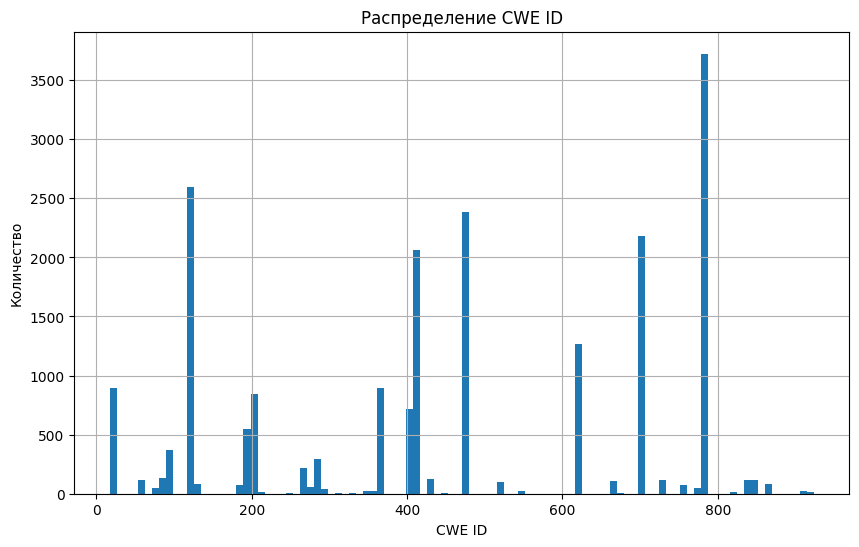

In [169]:
plt.figure(figsize=(10, 6))
df['cwe'].hist(bins=100)
plt.xlabel("CWE ID")
plt.ylabel("Количество") 
plt.title("Распределение CWE ID")  # Заголовок графика
plt.grid(True)  # Включаем сетку (опционально)
plt.show()  # Показываем график

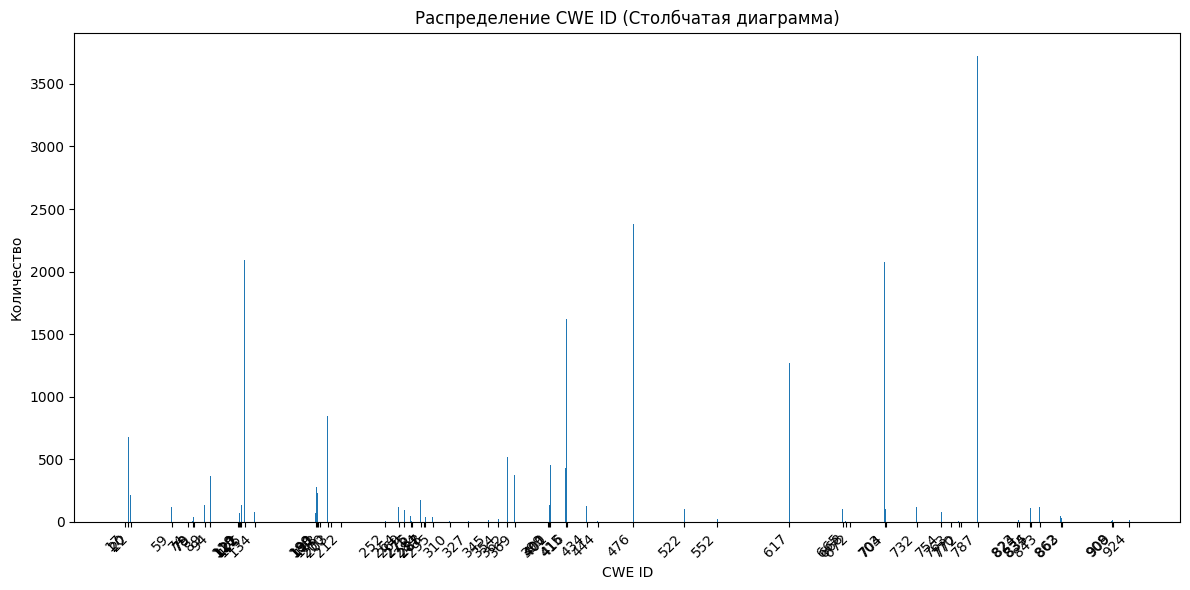

In [170]:
cwe_counts = df['cwe'].value_counts().sort_index()  # Считаем количество каждого CWE и сортируем по индексу
plt.figure(figsize=(12, 6))
bars = plt.bar(cwe_counts.index, cwe_counts.values)  # Строим столбчатую диаграмму

plt.xlabel("CWE ID")
plt.ylabel("Количество")
plt.title("Распределение CWE ID (Столбчатая диаграмма)")
plt.xticks(cwe_counts.index, rotation=45, ha='right')  # Задаем подписи для каждого столбца и поворачиваем их
plt.tight_layout()  # Предотвращаем обрезание подписей
plt.show()

In [175]:
df1 = df[df['cwe'] == 787]

In [178]:
df1

,idx,project,commit_id,project_url,commit_url,commit_message,target,func,func_hash,file_name,file_hash,cwe,cve,cve_desc,nvd_url
16,195055,tensorflow,2b7100d6cdff36aa21010a82269bc05a6d1cc74a,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Cleanup and remove duplicate validation in `Sp...,1,void Compute(OpKernelContext* context) overr...,115744370413617881150207979427400512016,count_ops.cc,2.908326e+38,787,CVE-2022-21740,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-21740
35,195233,tensorflow,97282c6d0d34476b6ba033f961590b783fa184cd,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Prevent a crash due to heap OOB write in grapp...,1,"Status SetUnknownShape(const NodeDef* node, ...",128649942367020682781968122888762734954,graph_properties.cc,2.473149e+36,787,CVE-2022-23566,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-23566
44,195289,tensorflow,adbbabdb0d3abb3cdeac69e38a96de1d678b24b3,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Further validate sparse tensor for `SparseCoun...,1,void Compute(OpKernelContext* context) overr...,100138829425874082218930421940516836043,count_ops.cc,2.217786e+38,787,CVE-2022-21740,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-21740
49,195296,uWebSockets,03fca626a95130ab80f86adada54b29d27242759,https://github.com/uWebSockets/uWebSockets,https://github.com/uWebSockets/uWebSockets/com...,Fix overflow of triggered topics,1,"void publish(Topic *iterator, size_t start...",134169268379037550524482088626348972483,TopicTree.h,2.038132e+38,787,CVE-2020-36406,uWebSockets 18.11.0 and 18.12.0 has a stack-ba...,https://nvd.nist.gov/vuln/detail/CVE-2020-36406
75,195626,qemu,7882080388be5088e72c425b02223c02e6cb4295,https://github.com/bonzini/qemu,https://github.com/qemu/qemu/commit/7882080388...,virtio-serial: fix ANY_LAYOUT\n\nDon't assume ...,1,static size_t send_control_msg(VirtIOSerial *v...,301712778748262907171467771526276497164,virtio-serial-bus.c,2.531577e+38,787,CVE-2015-5745,Buffer overflow in the send_control_msg functi...,https://nvd.nist.gov/vuln/detail/CVE-2015-5745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19745,484733,libmobi,ab5bf0e37e540eac682a14e628853b918626e72b,https://github.com/bfabiszewski/libmobi,https://github.com/bfabiszewski/libmobi/commit...,fix oob write bug inside libmobi,0,"void mobi_buffer_dup16(uint16_t **val, MOBIBuf...",227557401043690561441193364183480390548,NaN,NaN,787,CVE-2021-3751,libmobi is vulnerable to Out-of-bounds Write,https://nvd.nist.gov/vuln/detail/CVE-2021-3751
19746,484734,libmobi,ab5bf0e37e540eac682a14e628853b918626e72b,https://github.com/bfabiszewski/libmobi,https://github.com/bfabiszewski/libmobi/commit...,fix oob write bug inside libmobi,0,"void mobi_buffer_add32(MOBIBuffer *buf, const ...",148349427128394901206602130282394058319,NaN,NaN,787,CVE-2021-3751,libmobi is vulnerable to Out-of-bounds Write,https://nvd.nist.gov/vuln/detail/CVE-2021-3751
19747,484735,libmobi,ab5bf0e37e540eac682a14e628853b918626e72b,https://github.com/bfabiszewski/libmobi,https://github.com/bfabiszewski/libmobi/commit...,fix oob write bug inside libmobi,0,"void mobi_buffer_dup8(uint8_t **val, MOBIBuffe...",216657206408639306868700337795456594692,NaN,NaN,787,CVE-2021-3751,libmobi is vulnerable to Out-of-bounds Write,https://nvd.nist.gov/vuln/detail/CVE-2021-3751
19748,484736,libmobi,ab5bf0e37e540eac682a14e628853b918626e72b,https://github.com/bfabiszewski/libmobi,https://github.com/bfabiszewski/libmobi/commit...,fix oob write bug inside libmobi,0,uint16_t mobi_buffer_get16(MOBIBuffer *buf) {\...,6191842848529715590183721332306024585,NaN,NaN,787,CVE-2021-3751,libmobi is vulnerable to Out-of-bounds Write,https://nvd.nist.gov/vuln/detail/CVE-2021-3751


In [64]:
df

,func,cwe,true_path,true_lvl0,true_lvl1,true_lvl2,true_lvl3,true_lvl4
0,cdf_read_property_info(const cdf_stream_t *sst...,787,"[664, 118, 119, 787]",664,118,119,787,None
1,"check_termcode(\n int\t\tmax_offset,\n c...",787,"[664, 118, 119, 787]",664,118,119,787,None
2,static void *seq_buf_alloc(unsigned long size)...,787,"[664, 118, 119, 787]",664,118,119,787,None
3,display_dollar(colnr_T col)\n{\n colnr_T sa...,787,"[664, 118, 119, 787]",664,118,119,787,None
4,static void parse_relocation_info(struct MACH0...,787,"[664, 118, 119, 787]",664,118,119,787,None
...,...,...,...,...,...,...,...,...
195,"int SSL_set_session(SSL *s, SSL_SESSION *sessi...",362,"[691, 362]",691,362,None,None,None
196,"TEST_P(SslSocketTest, FailedClientCertificateH...",362,"[691, 362]",691,362,None,None,None
197,"void SSL_CTX_sess_set_new_cb(SSL_CTX *ctx,\n ...",362,"[691, 362]",691,362,None,None,None
198,"static int remove_session_lock(SSL_CTX *ctx, S...",362,"[691, 362]",691,362,None,None,None


In [64]:
cwe_counts = df['cwe'].astype(str).str.split('.').str[0].value_counts()

In [188]:
top_10_cwe = cwe_counts.head(10).index

df_top10 = df[df['cwe'].isin(top_10_cwe)].copy() # .copy() чтобы избежать SettingWithCopyWarning

# Преобразуем 'cwe' в Categorical type с явным указанием порядка категорий
df_top10['cwe'] = pd.Categorical(df_top10['cwe'], categories=top_10_cwe, ordered=True)

# Сортируем DataFrame по колонке 'cwe'
df_top10 = df_top10.sort_values(by='cwe')

In [189]:
df_top10

,idx,project,commit_id,project_url,commit_url,commit_message,target,func,func_hash,file_name,file_hash,cwe,cve,cve_desc,nvd_url
16768,430354,linux,8cae8cd89f05f6de223d63e6d15e31c8ba9cf53b,https://github.com/torvalds/linux,https://github.com/torvalds/linux/commit/8cae8...,seq_file: disallow extremely large seq buffer ...,0,static void seq_set_overflow(struct seq_file *...,93129852599211418397869042588151443717,seq_file.c,3.066381e+38,787,CVE-2021-33909,fs/seq_file.c in the Linux kernel 3.16 through...,https://nvd.nist.gov/vuln/detail/CVE-2021-33909
5026,244155,gpac,77510778516803b7f7402d7423c6d6bef50254c3,https://github.com/gpac/gpac,https://github.com/gpac/gpac/commit/7751077851...,fixed #2255,0,GF_Box *pcmC_box_new()\n{\n\tISOM_DECL_BOX_ALL...,206030833572045808841620367380545249506,box_code_base.c,1.035819e+38,787,NaN,NaN,https://nvd.nist.gov/vuln/detail/None
5025,244154,gpac,77510778516803b7f7402d7423c6d6bef50254c3,https://github.com/gpac/gpac,https://github.com/gpac/gpac/commit/7751077851...,fixed #2255,0,GF_Box *trgr_box_new()\n{\n\tISOM_DECL_BOX_ALL...,338752274950158537784022454024723190687,box_code_base.c,1.035819e+38,787,NaN,NaN,https://nvd.nist.gov/vuln/detail/None
5024,244153,gpac,77510778516803b7f7402d7423c6d6bef50254c3,https://github.com/gpac/gpac,https://github.com/gpac/gpac/commit/7751077851...,fixed #2255,0,"GF_Err pdin_box_read(GF_Box *s, GF_BitStream *...",149712024607744012324041876694472797172,box_code_base.c,1.035819e+38,787,NaN,NaN,https://nvd.nist.gov/vuln/detail/None
5023,244152,gpac,77510778516803b7f7402d7423c6d6bef50254c3,https://github.com/gpac/gpac,https://github.com/gpac/gpac/commit/7751077851...,fixed #2255,0,void svhd_box_del(GF_Box *s)\n{\n\tGF_Spherica...,277535441707641145017903658112864298535,box_code_base.c,1.035819e+38,787,NaN,NaN,https://nvd.nist.gov/vuln/detail/None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,200695,linux,fc739a058d99c9297ef6bfd923b809d85855b9a9,https://github.com/torvalds/linux,https://github.com/torvalds/linux/commit/fc739...,misc: fastrpc: prevent memory leak in fastrpc_...,1,static int fastrpc_dma_buf_attach(struct dma_b...,226882745088672382788622327400287132857,fastrpc.c,2.217077e+37,401,CVE-2019-19069,A memory leak in the fastrpc_dma_buf_attach() ...,https://nvd.nist.gov/vuln/detail/CVE-2019-19069
200,198736,linux,d563131ef23cbc756026f839a82598c8445bc45f,https://github.com/torvalds/linux,https://github.com/torvalds/linux/commit/d5631...,rsi: release skb if rsi_prepare_beacon fails\n...,1,static int rsi_send_beacon(struct rsi_common *...,130931178778692254191224779038755080046,rsi_91x_mgmt.c,1.256600e+38,401,CVE-2019-19071,A memory leak in the rsi_send_beacon() functio...,https://nvd.nist.gov/vuln/detail/CVE-2019-19071
19518,481287,linux,c8c2a057fdc7de1cd16f4baa51425b932a42eb39,https://github.com/torvalds/linux,https://github.com/torvalds/linux/commit/c8c2a...,net/mlx5: prevent memory leak in mlx5_fpga_con...,0,int mlx5_fpga_conn_device_init(struct mlx5_fpg...,60373611803659005709286515510746172322,conn.c,1.792015e+38,401,CVE-2019-19045,A memory leak in the mlx5_fpga_conn_create_cq(...,https://nvd.nist.gov/vuln/detail/CVE-2019-19045
872,220163,tensorflow,ab51e5b813573dc9f51efa335aebcf2994125ee9,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Prevent memory leak in decoding PNG images.\n\...,0,void DecodeImageV2Op::DecodeBMP(const uint8* i...,309175657452815640759126829221529246538,decode_image_op.cc,2.503712e+38,401,CVE-2022-23585,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-23585


In [192]:
target_count = df['target'].value_counts()

In [193]:
target_count

target
0    20055
1      549
Name: count, dtype: int64

In [206]:
df_top10['func'][16768]

'static void seq_set_overflow(struct seq_file *m)\n{\n\tm->count = m->size;\n}'

In [203]:
df_top10

,idx,project,commit_id,project_url,commit_url,commit_message,target,func,func_hash,file_name,file_hash,cwe,cve,cve_desc,nvd_url
16768,430354,linux,8cae8cd89f05f6de223d63e6d15e31c8ba9cf53b,https://github.com/torvalds/linux,https://github.com/torvalds/linux/commit/8cae8...,seq_file: disallow extremely large seq buffer ...,0,static void seq_set_overflow(struct seq_file *...,93129852599211418397869042588151443717,seq_file.c,3.066381e+38,787,CVE-2021-33909,fs/seq_file.c in the Linux kernel 3.16 through...,https://nvd.nist.gov/vuln/detail/CVE-2021-33909
5026,244155,gpac,77510778516803b7f7402d7423c6d6bef50254c3,https://github.com/gpac/gpac,https://github.com/gpac/gpac/commit/7751077851...,fixed #2255,0,GF_Box *pcmC_box_new()\n{\n\tISOM_DECL_BOX_ALL...,206030833572045808841620367380545249506,box_code_base.c,1.035819e+38,787,NaN,NaN,https://nvd.nist.gov/vuln/detail/None
5025,244154,gpac,77510778516803b7f7402d7423c6d6bef50254c3,https://github.com/gpac/gpac,https://github.com/gpac/gpac/commit/7751077851...,fixed #2255,0,GF_Box *trgr_box_new()\n{\n\tISOM_DECL_BOX_ALL...,338752274950158537784022454024723190687,box_code_base.c,1.035819e+38,787,NaN,NaN,https://nvd.nist.gov/vuln/detail/None
5024,244153,gpac,77510778516803b7f7402d7423c6d6bef50254c3,https://github.com/gpac/gpac,https://github.com/gpac/gpac/commit/7751077851...,fixed #2255,0,"GF_Err pdin_box_read(GF_Box *s, GF_BitStream *...",149712024607744012324041876694472797172,box_code_base.c,1.035819e+38,787,NaN,NaN,https://nvd.nist.gov/vuln/detail/None
5023,244152,gpac,77510778516803b7f7402d7423c6d6bef50254c3,https://github.com/gpac/gpac,https://github.com/gpac/gpac/commit/7751077851...,fixed #2255,0,void svhd_box_del(GF_Box *s)\n{\n\tGF_Spherica...,277535441707641145017903658112864298535,box_code_base.c,1.035819e+38,787,NaN,NaN,https://nvd.nist.gov/vuln/detail/None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,200695,linux,fc739a058d99c9297ef6bfd923b809d85855b9a9,https://github.com/torvalds/linux,https://github.com/torvalds/linux/commit/fc739...,misc: fastrpc: prevent memory leak in fastrpc_...,1,static int fastrpc_dma_buf_attach(struct dma_b...,226882745088672382788622327400287132857,fastrpc.c,2.217077e+37,401,CVE-2019-19069,A memory leak in the fastrpc_dma_buf_attach() ...,https://nvd.nist.gov/vuln/detail/CVE-2019-19069
200,198736,linux,d563131ef23cbc756026f839a82598c8445bc45f,https://github.com/torvalds/linux,https://github.com/torvalds/linux/commit/d5631...,rsi: release skb if rsi_prepare_beacon fails\n...,1,static int rsi_send_beacon(struct rsi_common *...,130931178778692254191224779038755080046,rsi_91x_mgmt.c,1.256600e+38,401,CVE-2019-19071,A memory leak in the rsi_send_beacon() functio...,https://nvd.nist.gov/vuln/detail/CVE-2019-19071
19518,481287,linux,c8c2a057fdc7de1cd16f4baa51425b932a42eb39,https://github.com/torvalds/linux,https://github.com/torvalds/linux/commit/c8c2a...,net/mlx5: prevent memory leak in mlx5_fpga_con...,0,int mlx5_fpga_conn_device_init(struct mlx5_fpg...,60373611803659005709286515510746172322,conn.c,1.792015e+38,401,CVE-2019-19045,A memory leak in the mlx5_fpga_conn_create_cq(...,https://nvd.nist.gov/vuln/detail/CVE-2019-19045
872,220163,tensorflow,ab51e5b813573dc9f51efa335aebcf2994125ee9,https://github.com/tensorflow/tensorflow,https://github.com/tensorflow/tensorflow/commi...,Prevent memory leak in decoding PNG images.\n\...,0,void DecodeImageV2Op::DecodeBMP(const uint8* i...,309175657452815640759126829221529246538,decode_image_op.cc,2.503712e+38,401,CVE-2022-23585,Tensorflow is an Open Source Machine Learning ...,https://nvd.nist.gov/vuln/detail/CVE-2022-23585


In [241]:
df_balanced = pd.DataFrame()

# Цикл по уникальным CWE
for cwe in cwe_counts.index:
    df_cwe = df_top10[df_top10['cwe'] == cwe].copy() # Выбираем строки для текущего CWE

    # Удаляем строки с target == 0 до тех пор, пока не останется <= 50 строк
    while len(df_cwe) > 50:
        df_zeros = df_cwe[df_cwe['target'] == 0] # Находим строки с target == 0
        if len(df_zeros) > 0:
            df_cwe = df_cwe.drop(df_zeros.index[0]) # Удаляем первую строку с target == 0
        else:
            # Если нет строк с target == 0, удаляем случайную строку
            df_cwe = df_cwe.drop(df_cwe.sample(n=1).index) # Удаляем случайную строку
            print(f"CWE {cwe}: Нет строк с target == 0, удаляем случайные")

    df_balanced = pd.concat([df_balanced, df_cwe])        

CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет строк с target == 0, удаляем случайные
CWE 787: Нет

In [24]:
df_balanced.to_csv('primevul_top10_500', index=False)

NameError: name 'df_balanced' is not defined

In [25]:
df_balanced = pd.read_csv('primevul_top10_500')

In [26]:
df_balanced.shape

(500, 15)

In [27]:
col = ['func', 'cwe']
df_balanced = df_balanced[col]

In [28]:
df_balanced

,func,cwe
0,cdf_read_property_info(const cdf_stream_t *sst...,787
1,"check_termcode(\n int\t\tmax_offset,\n c...",787
2,static void *seq_buf_alloc(unsigned long size)...,787
3,display_dollar(colnr_T col)\n{\n colnr_T sa...,787
4,static void parse_relocation_info(struct MACH0...,787
...,...,...
495,static int fastrpc_dma_buf_attach(struct dma_b...,401
496,static int rsi_send_beacon(struct rsi_common *...,401
497,int mlx5_fpga_conn_device_init(struct mlx5_fpg...,401
498,void DecodeImageV2Op::DecodeBMP(const uint8* i...,401


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("leanseen/bigvul")

print("Path to dataset files:", path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38.5M/38.5M [01:35<00:00, 421kB/s]

Extracting files...


Path to dataset files: /home/jam/.cache/kagglehub/datasets/leanseen/bigvul/versions/1


In [2]:
import pandas as pd
import os

# Путь к датасету
dataset_path = '/home/jam/.cache/kagglehub/datasets/leanseen/bigvul/versions/1'

# Найдём нужный CSV-файл (обычно это all_c_cpp_release2.0.csv или аналог)
for file in os.listdir(dataset_path):
    if file.endswith('.csv'):
        csv_path = os.path.join(dataset_path, file)
        break

# Загружаем датасет
df = pd.read_csv(csv_path)

# Смотрим первые строки
df.head()

NameError: name 'csv_path' is not defined

In [4]:
import os

dataset_path = '/home/jam/.cache/kagglehub/datasets/leanseen/bigvul/versions/1'

# Посмотрим, какие файлы лежат в этой папке
files = os.listdir(dataset_path)
print("Файлы в папке:", files)


Файлы в папке: ['CPG']
